<a href="https://colab.research.google.com/github/sreent/deep-learning/blob/main/credit_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

import itertools

## Problem Definition and Assembling Dataset

In [37]:
FILE_PATH = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

HEADERS = ['Status of existing checking account', 'Duration in month', 'Credit history',
           'Purpose','Credit amount', 'Savings account/bonds', 'Present employment since',
           'Installment rate in percentage of disposable income', 'Personal status and sex',
           'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
           'Other installment plans', 'Housing', 'Number of existing credits at this bank',
           'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 
           'Cost Matrix(Risk)']

TARGET_VARIABLE = 'Cost Matrix(Risk)'

In [51]:
NUMERICAL_VARIABLES = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income',
                     'Present residence since', 'Age in years', 'Number of existing credits at this bank', 
                     'Number of people being liable to provide maintenance for']
                     
CATEGORICAL_VARIABLES = {
    'Status of existing checking account': {
        'A14': 'no checking account', 'A11': '<0 DM', 'A12': '0 <= <200 DM', 
        'A13': '>= 200 DM'
    },
    
    'Credit history': {
        'A34': 'critical account', 'A33': 'delay in paying off',
        'A32': 'existing credits paid back duly till now',
        'A31': 'all credits at this bank paid back duly',
        'A30': 'no credits taken'
    },
                 
    'Purpose': {
        'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture/equipment', 
        'A43': 'radio/television', 'A44': 'domestic appliances', 'A45': 'repairs', 
        'A46': 'education', 'A47' : 'vacation', 'A48': 'retraining', 'A49': 'business',
        'A410': 'others'
    },

    'Savings account/bonds': {
        'A65': 'no savings account', 'A61': '<100 DM',
        'A62': '100 <= <500 DM', 'A63': '500 <= < 1000 DM', 'A64': '>= 1000 DM'
    },

    'Present employment since': {
        'A75': '>=7 years', 'A74': '4<= <7 years',  'A73': '1<= < 4 years', 
        'A72': '<1 years', 'A71': 'unemployed'
    },

    'Personal status and sex': {
        'A95': 'female:single', 'A94': 'male:married/widowed', 'A93': 'male:single', 
        'A92': 'female:divorced/separated/married', 'A91': 'male:divorced/separated'
    },

    'Other debtors / guarantors': {
        'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'
    },

    'Property': {
        'A121': 'real estate', 'A122': 'savings agreement/life insurance', 
        'A123': 'car or other', 'A124': 'unknown / no property'
    },

    'Other installment plans': {
        'A143': 'none', 'A142': 'store', 'A141': 'bank'
    },
    
    'Housing': {
        'A153': 'for free', 'A152': 'own', 'A151': 'rent'
    },

    'Job': {
        'A174': 'management/ highly qualified employee', 
        'A173': 'skilled employee / official', 'A172': 'unskilled - resident', 
        'A171': 'unemployed/ unskilled  - non-resident'
    },
    
    'Telephone': {
        'A192': 'yes', 'A191': 'none'
    },

    'Foreign worker': {
        'A201': 'yes', 'A202': 'no'
    }
}

In [52]:
# Load loan data from URL using pandas read_csv method
df = pd.read_csv(FILE_PATH, sep=" ", header=None)

# The data file is headless, i.e. without column names. Hence, we've to assign the column names to our data frame. 
df.columns = HEADERS

# Preview data to check if the column names are assigned properly and also the columns' variable types
df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [53]:
# Target columns
target = df[TARGET_VARIABLE]

# Reformat entries to be either 0 (not default) and 1 (default), instead of 1 and 2. 
# This format is preferred in case of binary classificaiton problem.
target = target - 1

# Preview if 
print("The target column is now re-valued from [1, 2] to", target.unique(), ".")

The target column is now re-valued from [1, 2] to [0 1] .


In [138]:
# Feature columns to be used as predictors
features = df.drop(columns=[TARGET_VARIABLE])

# Replace encoded entries, e.g. Axxx, with their orignal values
for column, attributes in CATEGORICAL_VARIABLES.items() :
  features[column] = features[column].map(attributes) 

features.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,4,real estate,67,none,own,2,skilled employee / official,1,yes,yes
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,4,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## Evaluation Protocol

## Data Preparation

In [213]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True, stratify=target.values)

In [215]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), list(CATEGORICAL_VARIABLES.keys())),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [216]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

y_train, y_test = y_train.values, y_test.values

In [157]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

## Developing Model that does better than a baseline

In [159]:
INPUT_DIMENSION = X_train.shape[1]

model = Sequential()
#model.add(layers.Dense(INPUT_DIMENSION, activation='relu', input_shape=(INPUT_DIMENSION,)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(1, activation='sigmoid'))

#model.add(layers.Dense(INPUT_DIMENSION, activation='relu', input_shape=(INPUT_DIMENSION,)))
#model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(INPUT_DIMENSION,)))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

model.fit(X_train, y_train, batch_size=64, epochs=50, 
          validation_data=(X_val, y_val), verbose=0)
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.5169 - auc_13: 0.7645


[0.5168579816818237, 0.7645238041877747]

In [160]:
print(roc_auc_score(y_test, model.predict(X_test)))
print(accuracy_score(y_test, (model.predict(X_test) > 0.5).astype('int32')))

7/7 [==============================] - 0s 3ms/step
0.7644047619047619
7/7 [==============================] - 0s 2ms/step
0.745


In [206]:
X_train

array([[ 0.        ,  1.        ,  0.        , ...,  1.05778394,
        -0.71874547, -0.43643578],
       [ 0.        ,  0.        ,  0.        , ...,  0.24244893,
        -0.71874547, -0.43643578],
       [ 0.        ,  1.        ,  0.        , ..., -0.66347887,
         1.04504709, -0.43643578],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.69541282,
        -0.71874547, -0.43643578],
       [ 0.        ,  1.        ,  0.        , ..., -1.11644277,
         1.04504709, -0.43643578],
       [ 0.        ,  0.        ,  0.        , ..., -0.21051497,
        -0.71874547, -0.43643578]])

## Scaling Up: an Overfitted Model

In [168]:
model = Sequential()
model.add(Dense(42, activation='relu', input_shape=(INPUT_DIMENSION,)))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

model.fit(X_train, y_train, batch_size=32, epochs=50, 
          validation_data=(X_val, y_val), verbose=0)
model.evaluate(X_val, y_val)

5/5 [==============================] - 0s 4ms/step - loss: 0.6261 - auc_21: 0.7070


[0.626091718673706, 0.70703125]

In [169]:
model = Sequential()
model.add(Dense(42, activation='relu', input_shape=(INPUT_DIMENSION,)))
model.add(Dropout(0.5))
model.add(Dense(42, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()])

model.fit(X_train, y_train, batch_size=32, epochs=100, 
          validation_data=(X_val, y_val), verbose=0)
model.evaluate(X_val, y_val)

5/5 [==============================] - 0s 4ms/step - loss: 0.8065 - auc_22: 0.6818


[0.8064553141593933, 0.681826651096344]

## Regularisation and Hyper-Parameter Tuning

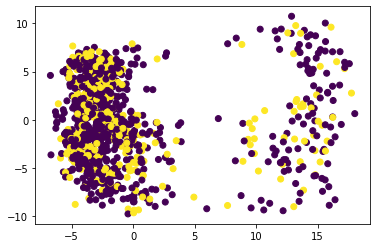

In [79]:
import matplotlib.pyplot as plt

plt.scatter(embedded[:,0], embedded[:,1], c=target)

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
 # create model
 model = Sequential()
 model.add(Dense(12, input_dim=8, activation='relu'))
 model.add(Dense(8, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 # Fit the model
 model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
 # evaluate the model
 scores = model.evaluate(X[test], Y[test], verbose=0)
 print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 cvscores.append(scores[1] * 100)
 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [217]:
def multilayer_perceptron(hidden_layers, neurons, activation, dropout, inputs, outputs) :
  model = Sequential()
  for layer in range(hidden_layers) :
    model.add(Dense(neurons, 
                    activation=activation, 
                    input_shape='default' if layer>1 else (inputs,)))
    model.add(Dropout(dropout))


  model.add(Dense(outputs, 
                  activation='sigmoid' if outputs==1 else 'softmax',
                  input_shape='defult' if hidden_layers>0 else (inputs,)))

  return model

In [237]:
def grid_search_cv(X, y, search_space, cv, metric, seed) :
  keys, values = zip(*search_space.items())

  avgs = []
  for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)

    scores = []
    for train, test in kfold.split(X, y):
      model = multilayer_perceptron(params['hidden_layers'], 
                                    params['neurons'], 
                                    params['activation'], 
                                    params['dropout'], INPUT_DIMENSION, 1)
      
      model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[metric])
      
      model.fit(X[train,:], y[train], batch_size=32, epochs=50, 
            validation_data=(X[test,:], y[test]), verbose=0)
      
      scores.append( model.evaluate(X[test], y[test], verbose=0)[1] )

    avgs.append([params, np.mean(scores)])

  df = pd.DataFrame(data=avgs, columns=['params', 'score'])

  df.sort_values(by=['score'], ascending=False)

  best_param = df.iloc[0]['params']
  best_score = df.iloc[0]['score']

  print(df.iloc[0])

  return best_param, best_score

In [238]:
params = {'hidden_layers': [1, 2],
          'neurons': [42],
          'activation': ['relu', 'sigmoid'],
          'dropout': [0.5]}

#params = {'hidden_layers': [1, 2, 3],
#          'neurons': [42],
#          'activation': ['relu', 'sigmoid'],
#          'dropout': [0.2, 0.3, 0.4, 0.5]}

best_param, best_score = grid_search_cv(X_train, y_train, params, 5, tf.keras.metrics.AUC(), 204)

params    {'hidden_layers': 1, 'neurons': 42, 'activatio...
score                                              0.774609
Name: 0, dtype: object


In [239]:
best_param, best_score

({'hidden_layers': 1, 'neurons': 42, 'activation': 'relu', 'dropout': 0.5},
 0.774609363079071)

In [236]:
best_param.keys()

AttributeError: ignored

In [ ]:
KFOLDS = 5

kfold = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=204)
cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
 model = Sequential()
 model.add(Dense(12, input_dim=8, activation='relu'))
 model.add(Dense(8, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 # Fit the model
 model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
 # evaluate the model
 scores = model.evaluate(X[test], Y[test], verbose=0)
 print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 cvscores.append(scores[1] * 100)
 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))




In [172]:
range(0)

range(0, 0)

In [173]:
for k  in range(0) :
  prinnt(k)